In [1]:
import numpy as np
import pandas as pd
from DenseLayer import DenseLayer
from ReluActivation import ReluActivation
from SoftmaxCategorical import SoftmaxCategorical
from CSVHandler import CSVHandler
from OptimizerSGD import OptimizerSGD
import os

In [2]:
x_train_path = os.path.join('../../../Task_2/x_train.csv')
y_train_path = os.path.join('../../../Task_2/y_train.csv')
x_test_path = os.path.join('../../../Task_2/x_test.csv')
y_test_path = os.path.join('../../../Task_2/y_test.csv')

In [3]:
x_train = pd.read_csv(x_train_path)
y_train = pd.read_csv(y_train_path)
x_test = pd.read_csv(x_test_path)
y_test = pd.read_csv(y_test_path)

In [4]:
y_train = np.eye(4)[y_train]
y_test = np.eye(4)[y_test]

In [5]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[2])
y_test = y_test.reshape(y_test.shape[0], y_test.shape[2])

In [6]:
# Neural network training function
def train_neural_network(layers, loss_activation, optimizer, X_train, y_train, X_test, y_test, epochs, learning_rate):
    train_costs = []
    test_costs = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Forward pass for training data
        inputs = X_train
        for layer in layers:
            layer.forward(inputs)
            if(layer.activation != None):
                layer.activation.forward(layer.output)
                inputs = layer.activation.output if hasattr(layer, 'activation') else layer.output
        
        # Calculate loss and accuracy for training data
        train_loss = loss_activation.forward(layers[-1].output, y_train)
        train_costs.append(train_loss)
        
        
        predictions = np.argmax(loss_activation.output, axis=1)
        predictions = np.eye(4)[predictions]
        train_accuracy = np.mean(predictions == y_train)
        train_accuracies.append(train_accuracy)

        # Backward pass (calculate gradients)
        loss_activation.backward(loss_activation.output, y_train)
        dinputs = loss_activation.dinputs
        for layer in reversed(layers):
            layer.backward(dinputs)
            dinputs = layer.dinputs

        # Update parameters using the optimizer
        for layer in layers:
            if hasattr(layer, 'weights'):  # Only update layers with weights
                optimizer.update_params(layer, learning_rate=learning_rate)

        # Forward pass for test data (for evaluation)
        inputs = X_test
        for layer in layers:
            layer.forward(inputs)
            if(layer.activation != None):
                layer.activation.forward(layer.output)
                inputs = layer.activation.output if hasattr(layer, 'activation') else layer.output
        
        # Calculate loss and accuracy for test data
        test_loss = loss_activation.forward(layers[-1].output, y_test)
        test_costs.append(test_loss)

        predictions = np.argmax(loss_activation.output, axis=1)
        predictions = np.eye(4)[predictions]
        accuracy = np.mean(predictions == y_test)
        test_accuracies.append(accuracy)

        # Print progress
        if(epoch == 0 or (epoch+1) % 100 == 0):
            print(f'Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f},Train Accuracy:{train_accuracy:4f} Accuracy: {accuracy:.4f}')

    return {
        'train_costs': train_costs,
        'test_costs': test_costs,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }

In [7]:
weights_path = os.path.join('../../b/w-100-40-4.csv')
biases_path = os.path.join('../../b/b-100-40-4.csv')

weights = pd.read_csv(weights_path, header=None)
weights = weights.T
weights.columns = weights.iloc[0]
weights = weights[1:]

biases = pd.read_csv(biases_path, header=None)
biases = biases.T
biases.columns = biases.iloc[0]
biases = biases[1:]

b1 = np.array(biases.iloc[:,0], dtype=np.float32)
b2 = np.array(biases.iloc[:40,1], dtype=np.float32)
b3 = np.array(biases.iloc[:4,2], dtype=np.float32)

w1 = np.array(weights.iloc[:,0:14], dtype=np.float32).T
w2 = np.array(weights.iloc[:40,14:114], dtype=np.float32).T
w3 = np.array(weights.iloc[:4,114:], dtype=np.float32).T

In [8]:
learning_rates = [1, 0.1, 0.001]
final_results = {}

for lr in learning_rates:
    layers = [
        DenseLayer(14, 100, activation=ReluActivation(), weights=w1.copy(), biases=b1.copy()),
        DenseLayer(100, 40, activation=ReluActivation(), weights=w2.copy(), biases=b2.copy()),
        DenseLayer(40, 4, weights=w3.copy(), biases=b3.copy())  # Output layer
    ]


    loss_activation = SoftmaxCategorical()
    optimizer = OptimizerSGD(clip_value=1.0)


    print(f'Training with learning rate: {lr}')
    # Call the train function
    results = train_neural_network(
        layers=layers,
        loss_activation=loss_activation,
        optimizer=optimizer,
        X_train=x_train,
        y_train=y_train,
        X_test=x_test,
        y_test=y_test,
        epochs=500,
        learning_rate=lr
    )

    final_results[lr] = results

Training with learning rate: 1
Epoch 1/500 - Loss: 12.0115, Test Loss: 11.4637,Train Accuracy:0.618114 Accuracy: 0.6444
Epoch 100/500 - Loss: 1.7617, Test Loss: 1.5133,Train Accuracy:0.599268 Accuracy: 0.6021
Epoch 200/500 - Loss: 2.2178, Test Loss: 2.1146,Train Accuracy:0.640775 Accuracy: 0.6487
Epoch 300/500 - Loss: 1.4783, Test Loss: 1.5801,Train Accuracy:0.642187 Accuracy: 0.6438
Epoch 400/500 - Loss: 1.5026, Test Loss: 1.5335,Train Accuracy:0.641882 Accuracy: 0.6445
Epoch 500/500 - Loss: 1.6039, Test Loss: 1.5045,Train Accuracy:0.642149 Accuracy: 0.6439
Training with learning rate: 0.1
Epoch 1/500 - Loss: 12.0115, Test Loss: 11.4007,Train Accuracy:0.618114 Accuracy: 0.6340
Epoch 100/500 - Loss: 2.1476, Test Loss: 2.2073,Train Accuracy:0.695063 Accuracy: 0.6754
Epoch 200/500 - Loss: 1.3403, Test Loss: 1.3289,Train Accuracy:0.704029 Accuracy: 0.6978
Epoch 300/500 - Loss: 1.2434, Test Loss: 1.2605,Train Accuracy:0.706699 Accuracy: 0.6998
Epoch 400/500 - Loss: 1.2254, Test Loss: 1.238

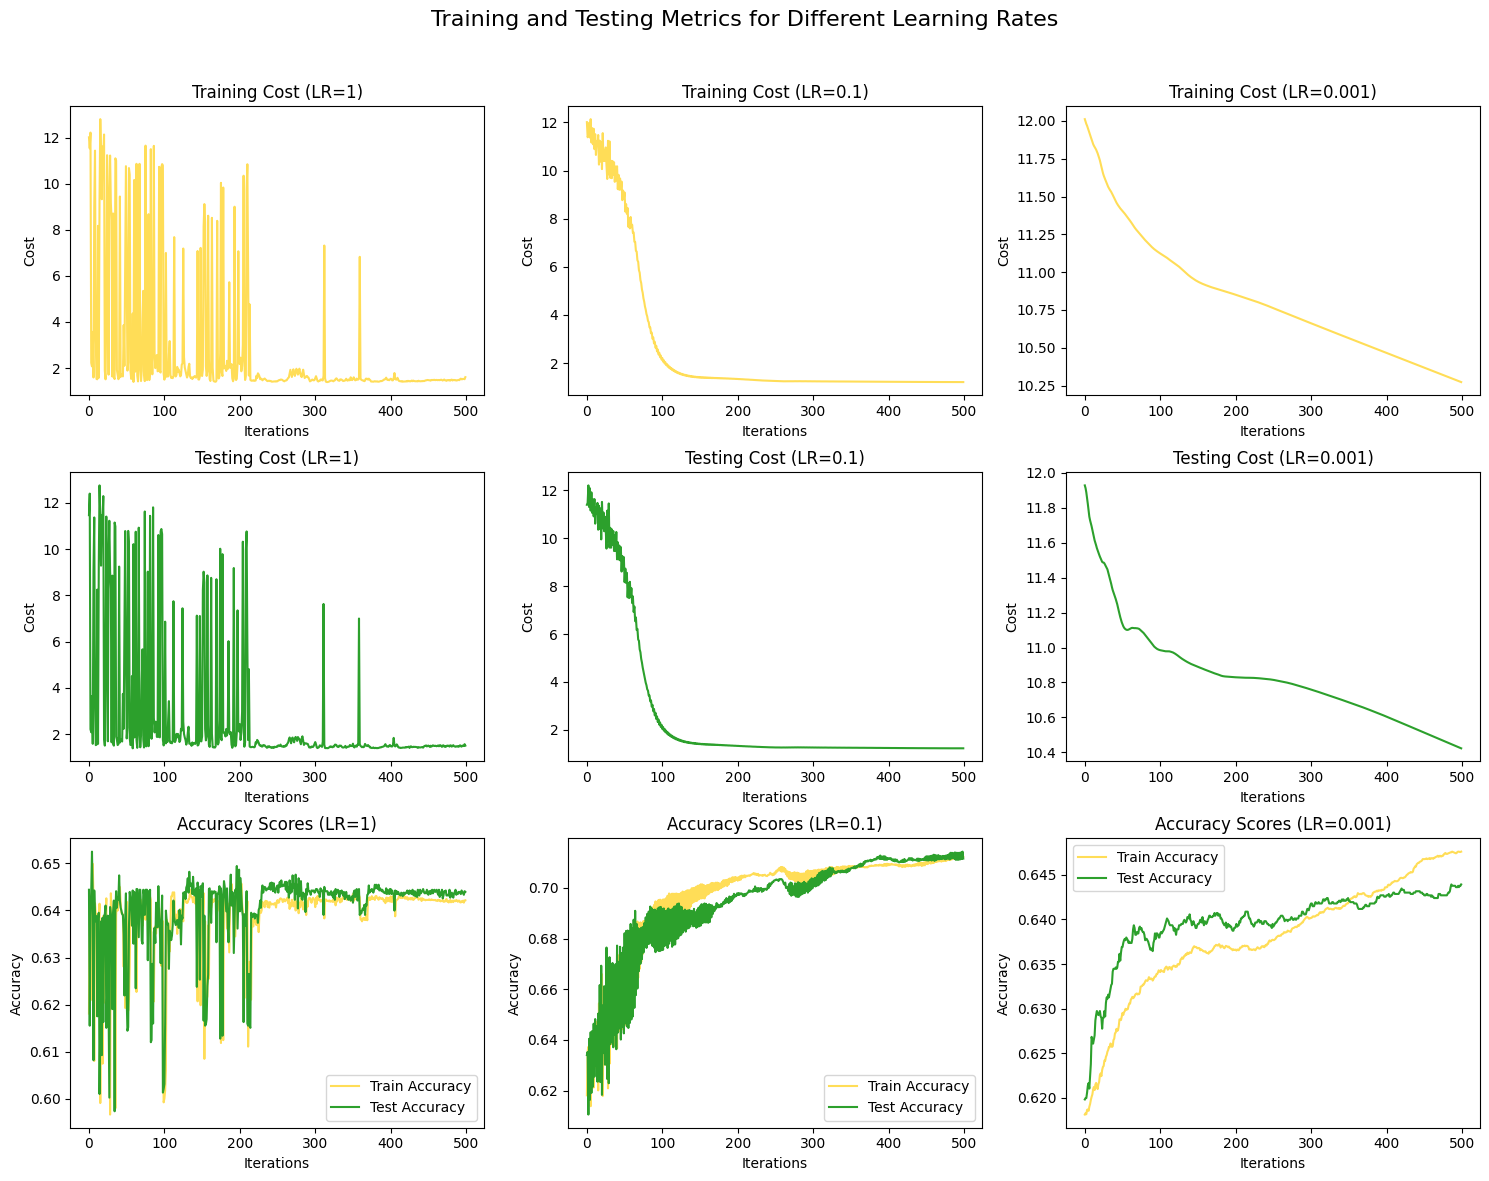

In [12]:
import matplotlib.pyplot as plt

# Plotting results
def plot_results(results_per_lr):
    fig, axs = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle('Training and Testing Metrics for Different Learning Rates', fontsize=16)

    for idx, lr in enumerate(learning_rates):
        results = results_per_lr[lr]
        train_costs = results['train_costs']
        test_costs = results['test_costs']
        train_accuracies = results['train_accuracies']
        test_accuracies = results['test_accuracies']

        # Color scheme using yellow and green
        axs[0, idx].plot(train_costs, label=f'LR={lr}', color='#ffdd57')  # Yellow for training cost
        axs[0, idx].set_title(f'Training Cost (LR={lr})')
        axs[0, idx].set_xlabel('Iterations')
        axs[0, idx].set_ylabel('Cost')

        axs[1, idx].plot(test_costs, label=f'LR={lr}', color='#2ca02c')  # Green for testing cost
        axs[1, idx].set_title(f'Testing Cost (LR={lr})')
        axs[1, idx].set_xlabel('Iterations')
        axs[1, idx].set_ylabel('Cost')

        axs[2, idx].plot(train_accuracies, label='Train Accuracy', color='#ffdd57')  # Yellow for train accuracy
        axs[2, idx].plot(test_accuracies, label='Test Accuracy', color='#2ca02c')    # Green for test accuracy
        axs[2, idx].set_title(f'Accuracy Scores (LR={lr})')
        axs[2, idx].set_xlabel('Iterations')
        axs[2, idx].set_ylabel('Accuracy')
        axs[2, idx].legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

plot_results(final_results)


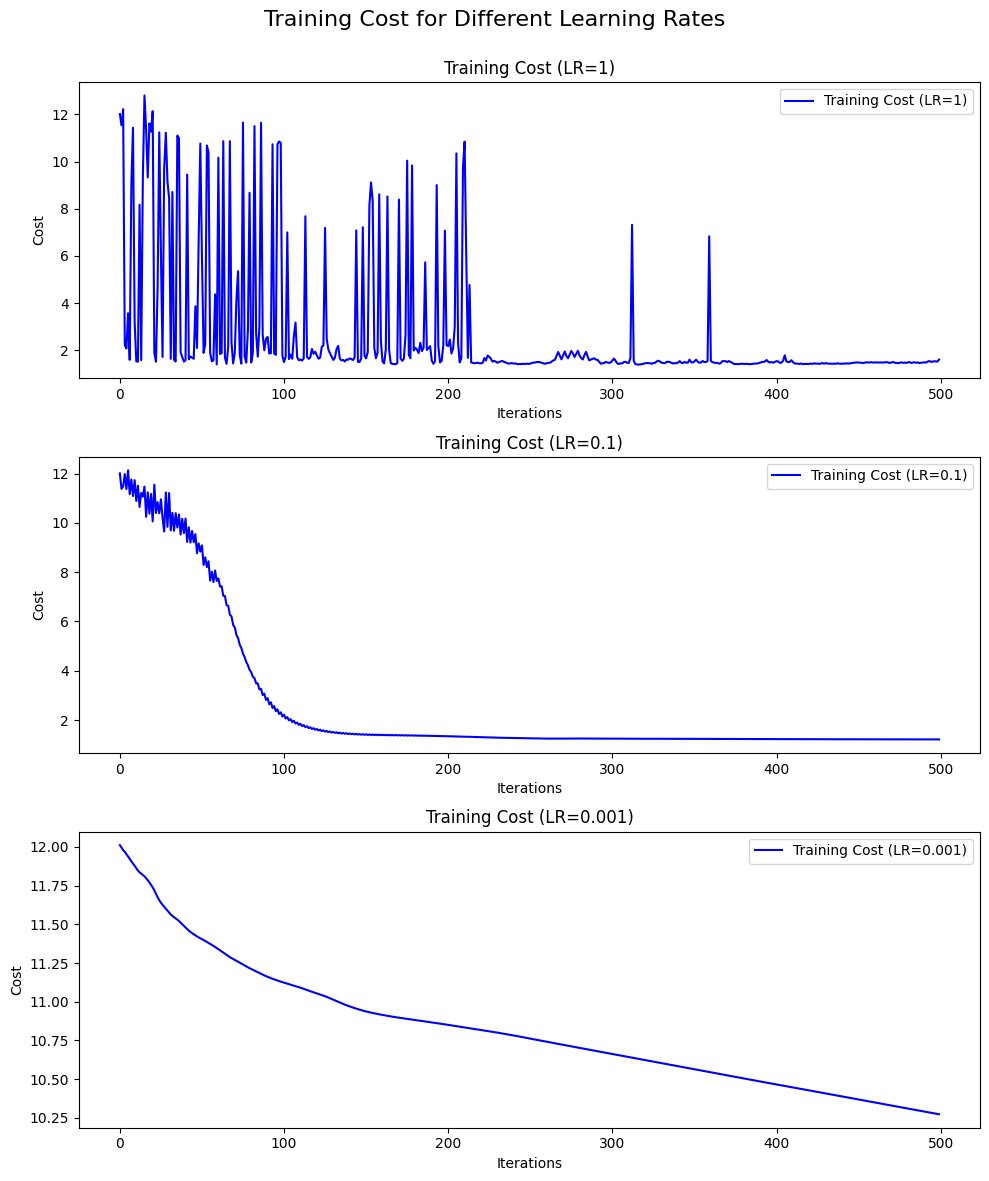

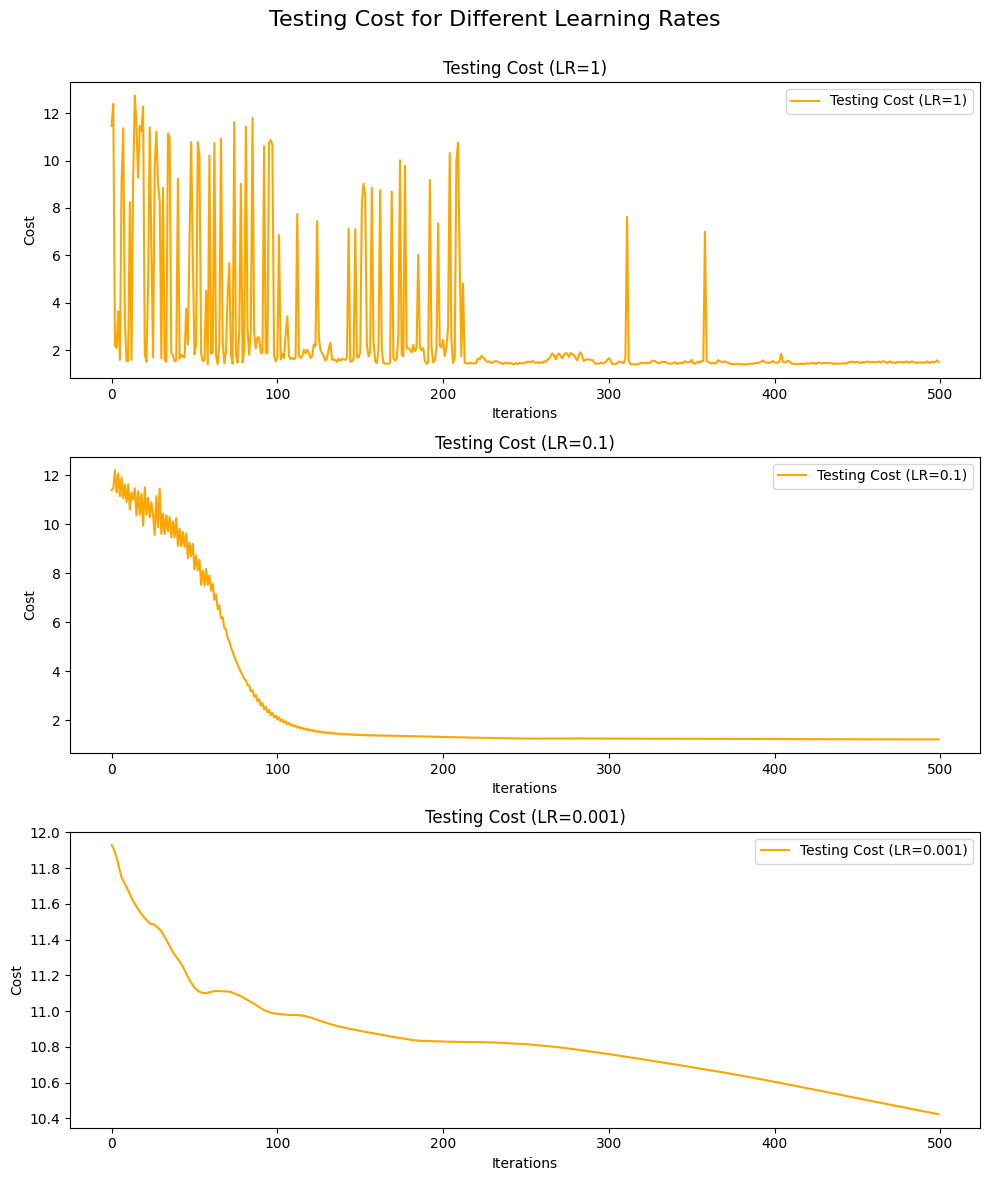

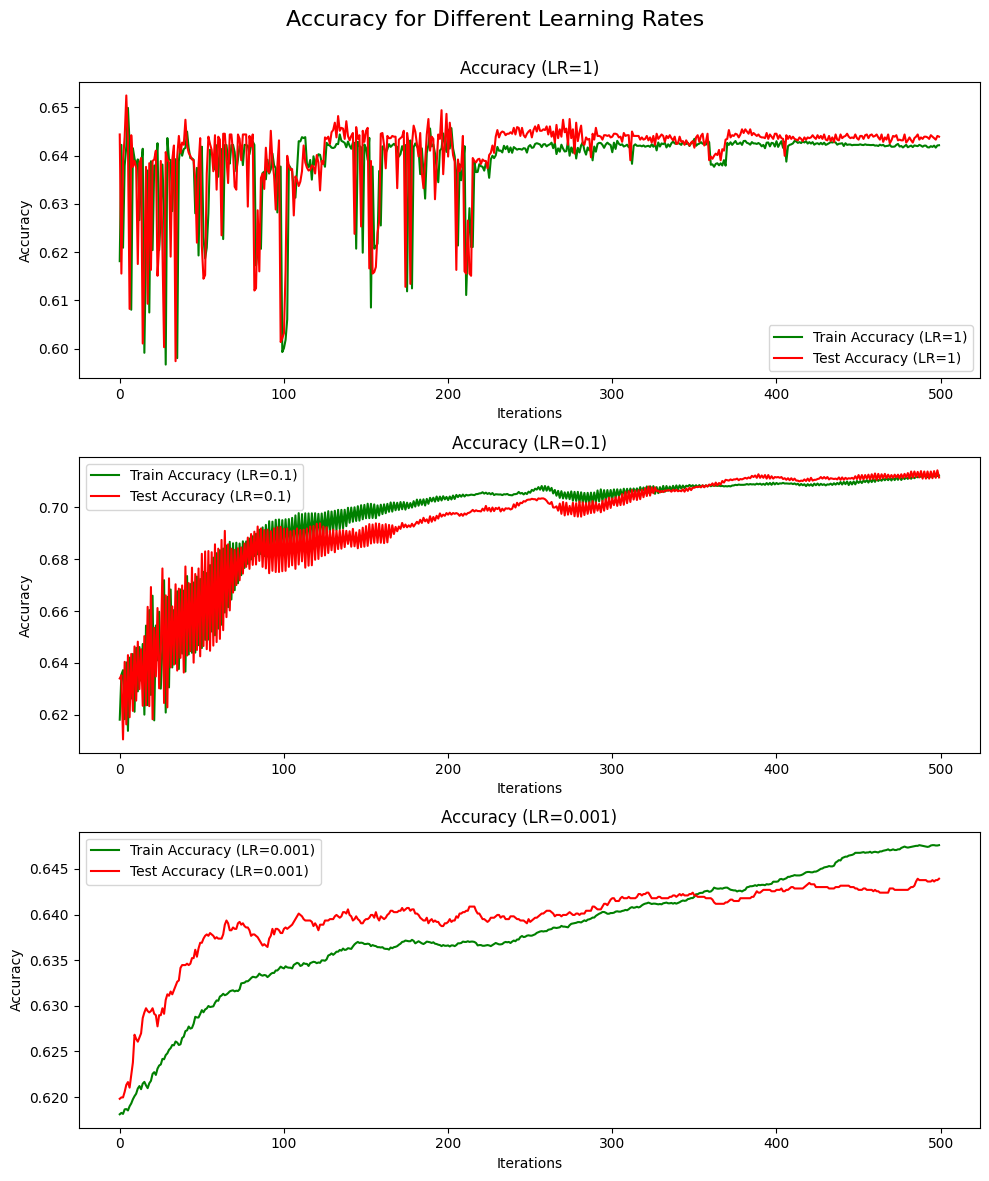

In [47]:
import matplotlib.pyplot as plt

# Plotting results
def plot_results_grouped_by_type(results_per_lr, learning_rates):
    # Create figure for training cost
    fig_train, axs_train = plt.subplots(3, 1, figsize=(10, 12))
    fig_train.suptitle('Training Cost for Different Learning Rates', fontsize=16)
    for i, lr in enumerate(learning_rates):
        train_costs = results_per_lr[lr]['train_costs']
        axs_train[i].plot(train_costs, label=f'Training Cost (LR={lr})', color='blue')
        axs_train[i].set_title(f'Training Cost (LR={lr})')
        axs_train[i].set_xlabel('Iterations')
        axs_train[i].set_ylabel('Cost')
        axs_train[i].legend()
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

    # Create figure for testing cost
    fig_test, axs_test = plt.subplots(3, 1, figsize=(10, 12))
    fig_test.suptitle('Testing Cost for Different Learning Rates', fontsize=16)
    for i, lr in enumerate(learning_rates):
        test_costs = results_per_lr[lr]['test_costs']
        axs_test[i].plot(test_costs, label=f'Testing Cost (LR={lr})', color='orange')
        axs_test[i].set_title(f'Testing Cost (LR={lr})')
        axs_test[i].set_xlabel('Iterations')
        axs_test[i].set_ylabel('Cost')
        axs_test[i].legend()
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

    # Create figure for accuracy scores
    fig_acc, axs_acc = plt.subplots(3, 1, figsize=(10, 12))
    fig_acc.suptitle('Accuracy for Different Learning Rates', fontsize=16)
    for i, lr in enumerate(learning_rates):
        train_accuracies = results_per_lr[lr]['train_accuracies']
        test_accuracies = results_per_lr[lr]['test_accuracies']
        axs_acc[i].plot(train_accuracies, label=f'Train Accuracy (LR={lr})', color='green')
        axs_acc[i].plot(test_accuracies, label=f'Test Accuracy (LR={lr})', color='red')
        axs_acc[i].set_title(f'Accuracy (LR={lr})')
        axs_acc[i].set_xlabel('Iterations')
        axs_acc[i].set_ylabel('Accuracy')
        axs_acc[i].legend()
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Example usage
plot_results_grouped_by_type(final_results, learning_rates)



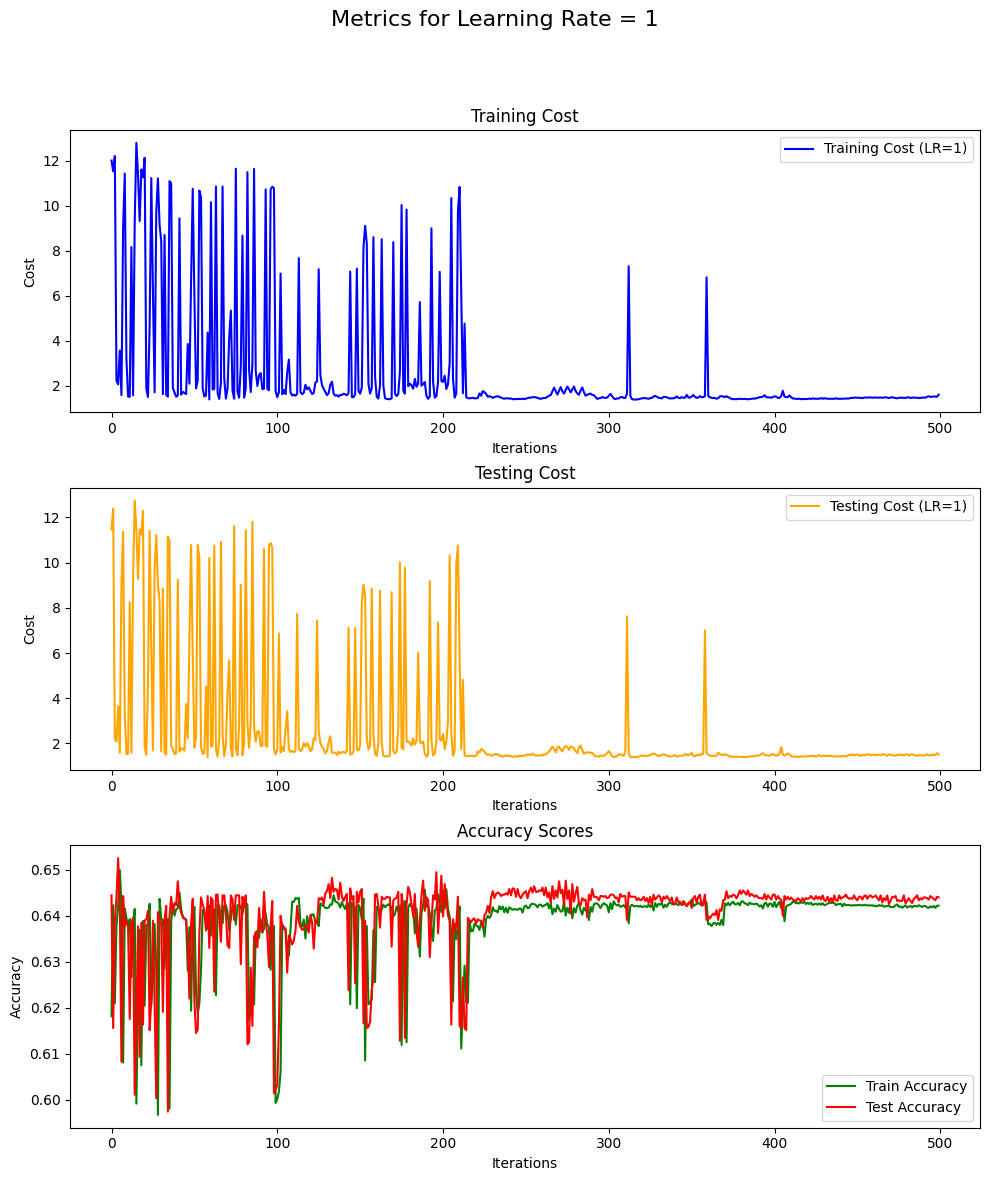

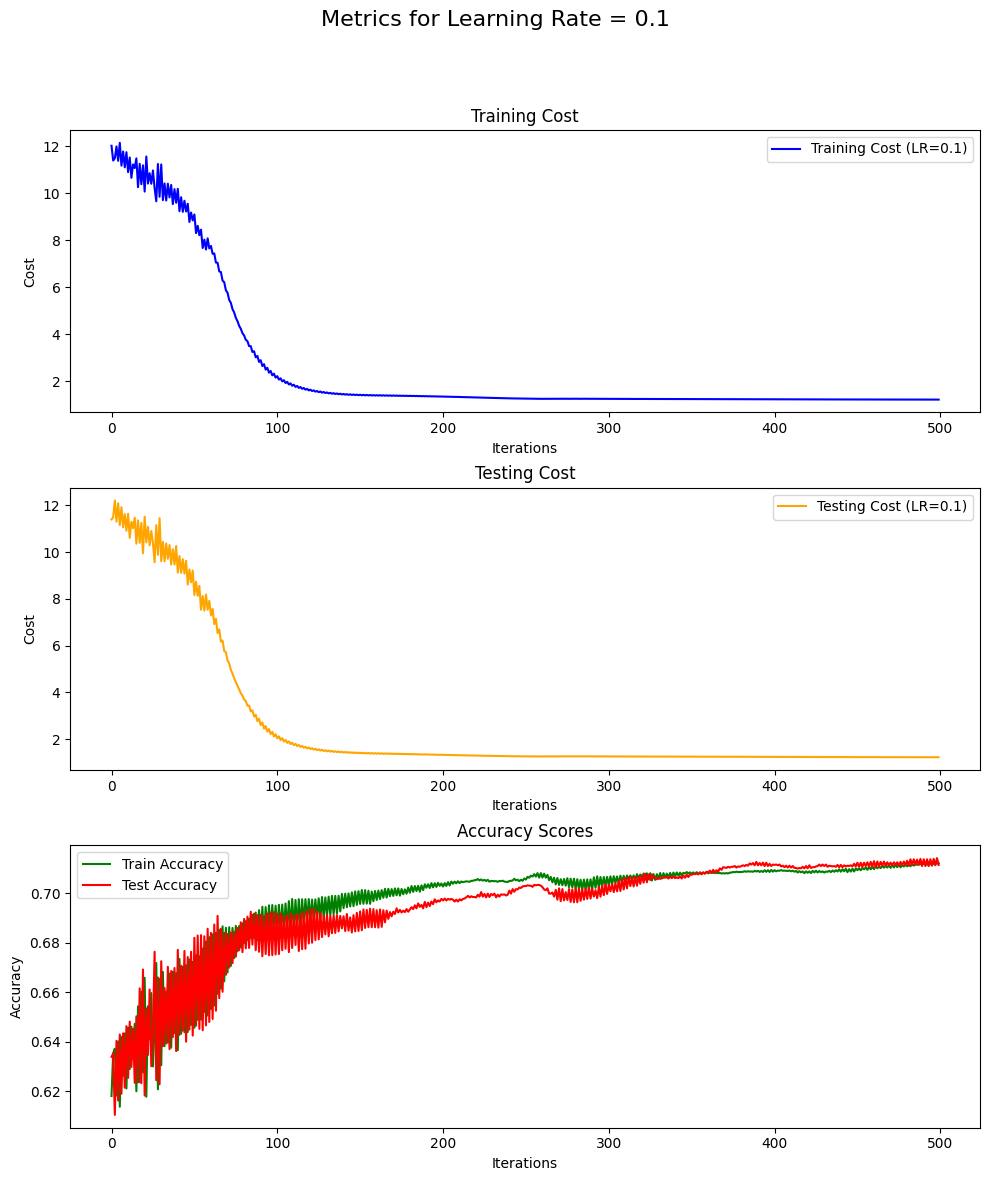

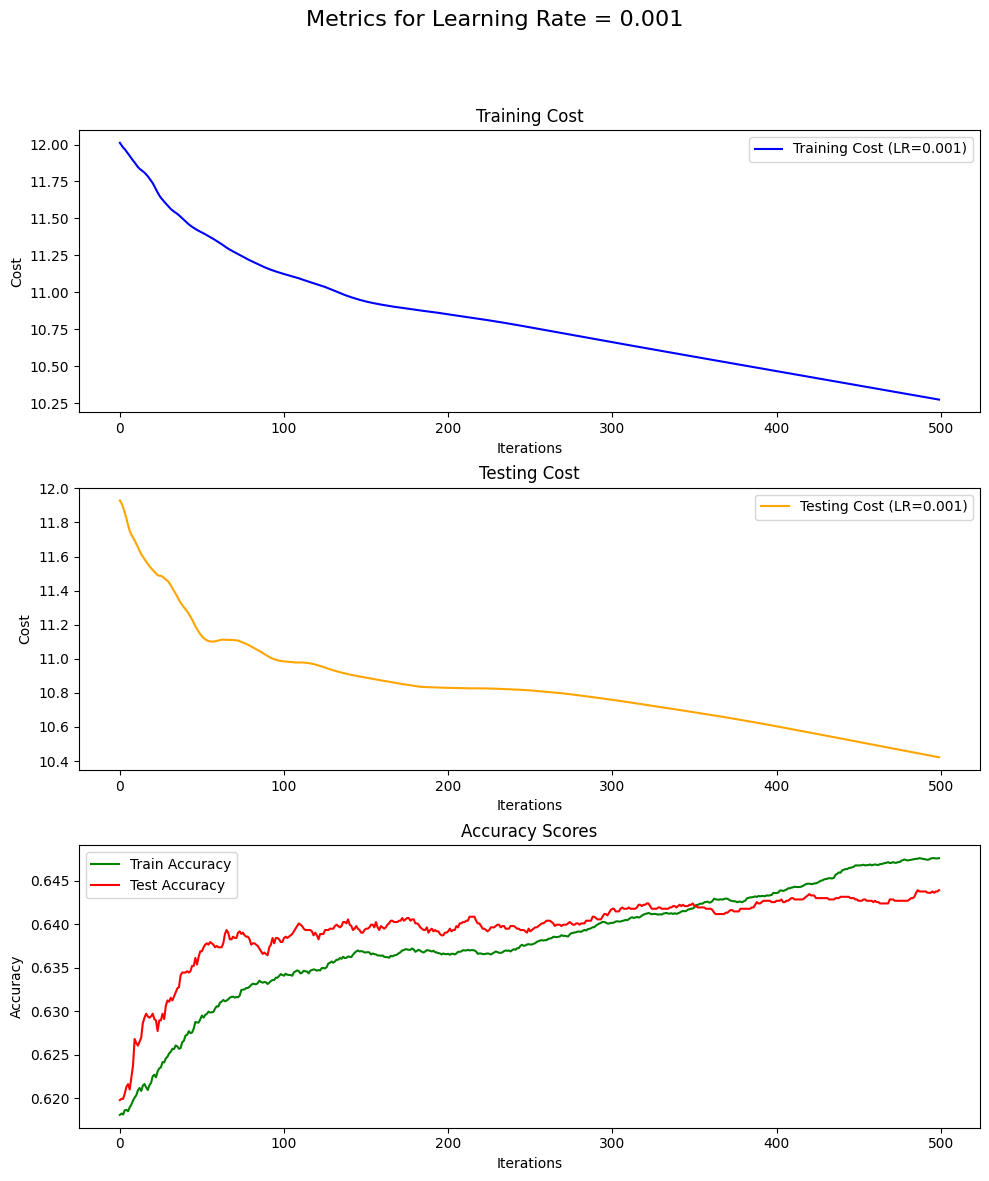

In [43]:
import matplotlib.pyplot as plt

# Plotting results
def plot_results_separately(results_per_lr):
    for lr in learning_rates:
        results = results_per_lr[lr]
        train_costs = results['train_costs']
        test_costs = results['test_costs']
        train_accuracies = results['train_accuracies']
        test_accuracies = results['test_accuracies']

        # Create a new figure for each learning rate
        fig, axs = plt.subplots(3, 1, figsize=(10, 12))
        fig.suptitle(f'Metrics for Learning Rate = {lr}', fontsize=16)

        # Training cost plot
        axs[0].plot(train_costs, label=f'Training Cost (LR={lr})', color='blue')
        axs[0].set_title('Training Cost')
        axs[0].set_xlabel('Iterations')
        axs[0].set_ylabel('Cost')
        axs[0].legend()

        # Testing cost plot
        axs[1].plot(test_costs, label=f'Testing Cost (LR={lr})', color='orange')
        axs[1].set_title('Testing Cost')
        axs[1].set_xlabel('Iterations')
        axs[1].set_ylabel('Cost')
        axs[1].legend()
# 
        # Accuracy scores plot
        axs[2].plot(train_accuracies, label='Train Accuracy', color='green')
        axs[2].plot(test_accuracies, label='Test Accuracy', color='red')
        axs[2].set_title('Accuracy Scores')
        axs[2].set_xlabel('Iterations')
        axs[2].set_ylabel('Accuracy')
        axs[2].legend()

        # Adjust layout and show
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.show()

# Call the function to plot
plot_results_separately(final_results)


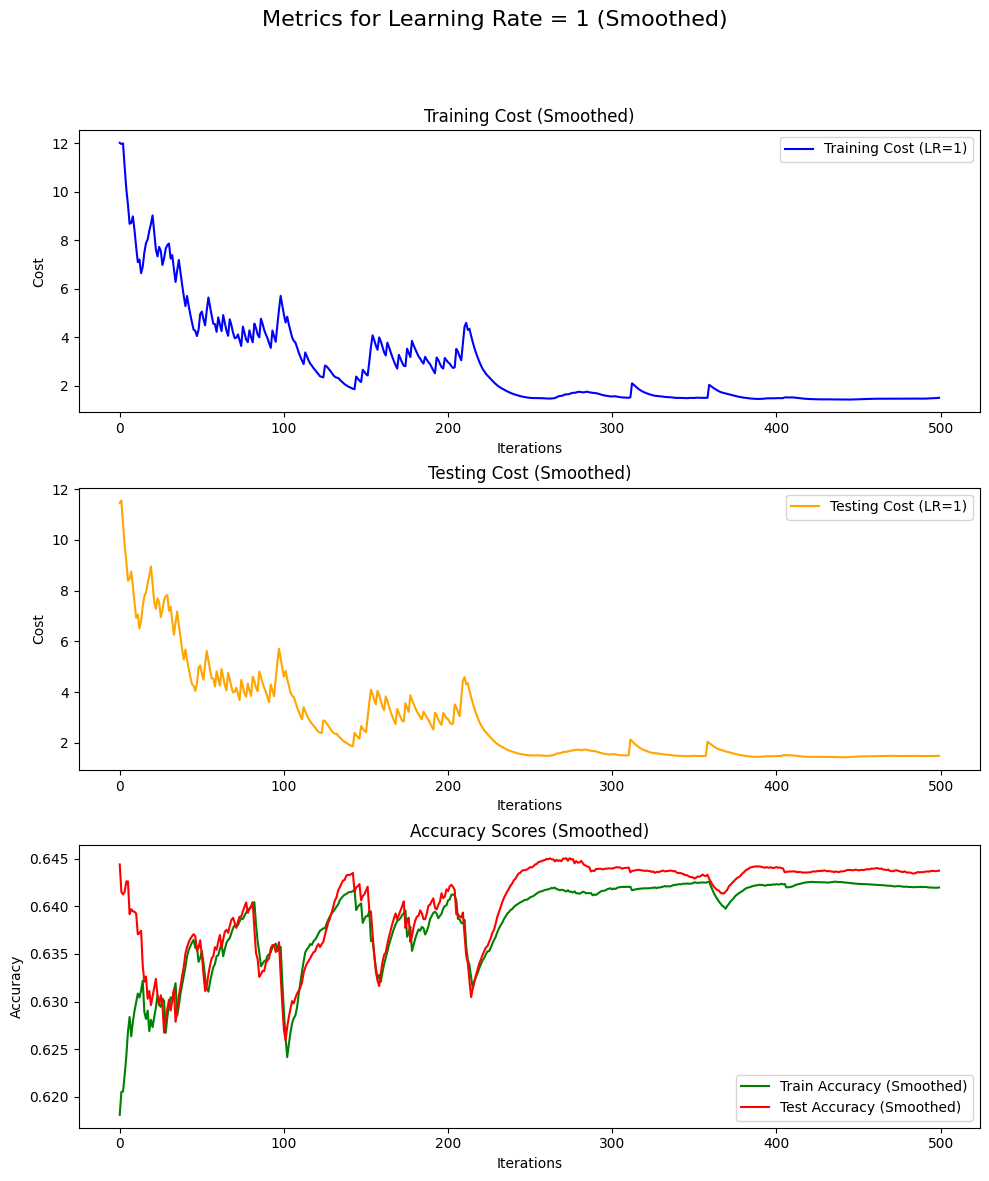

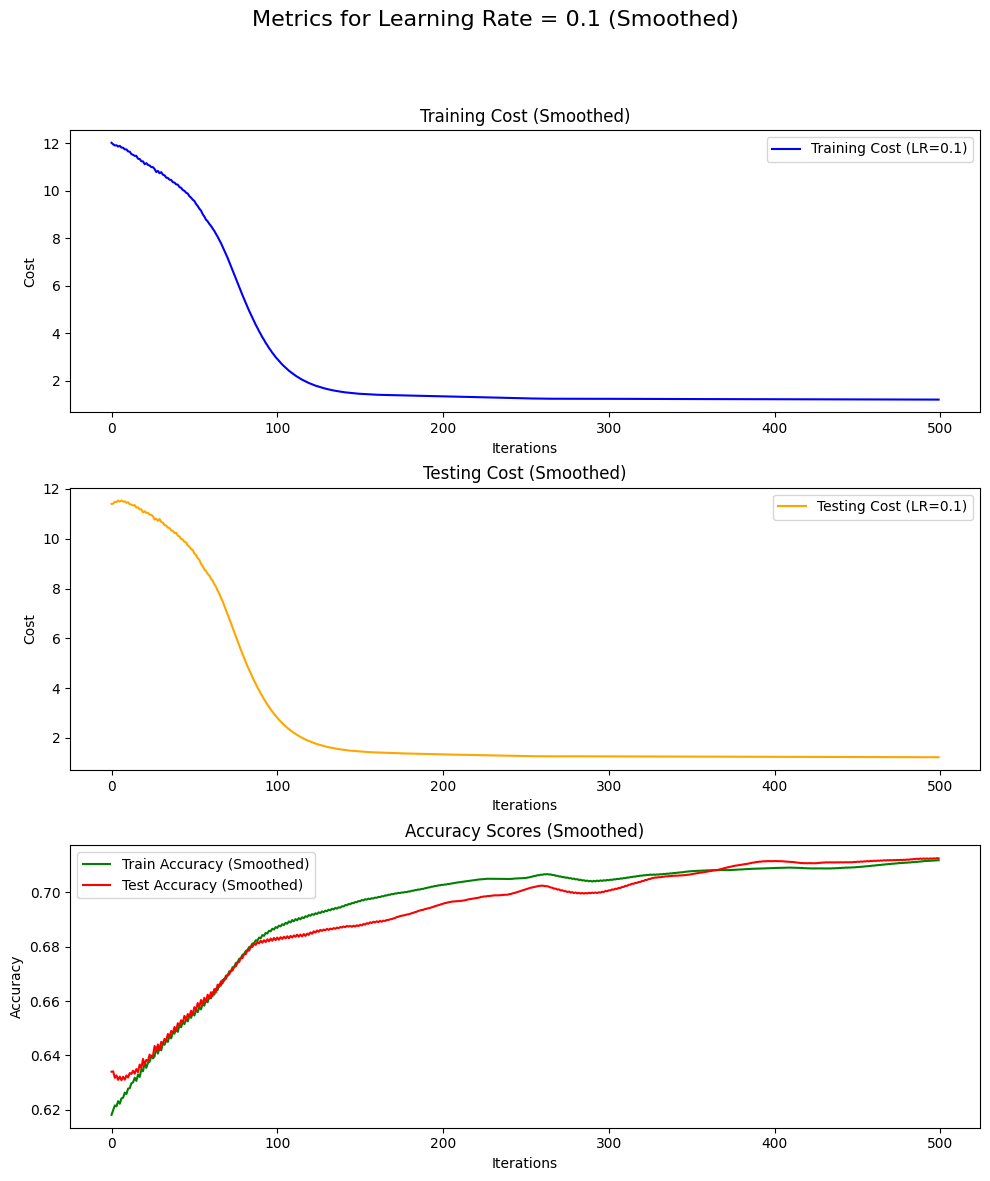

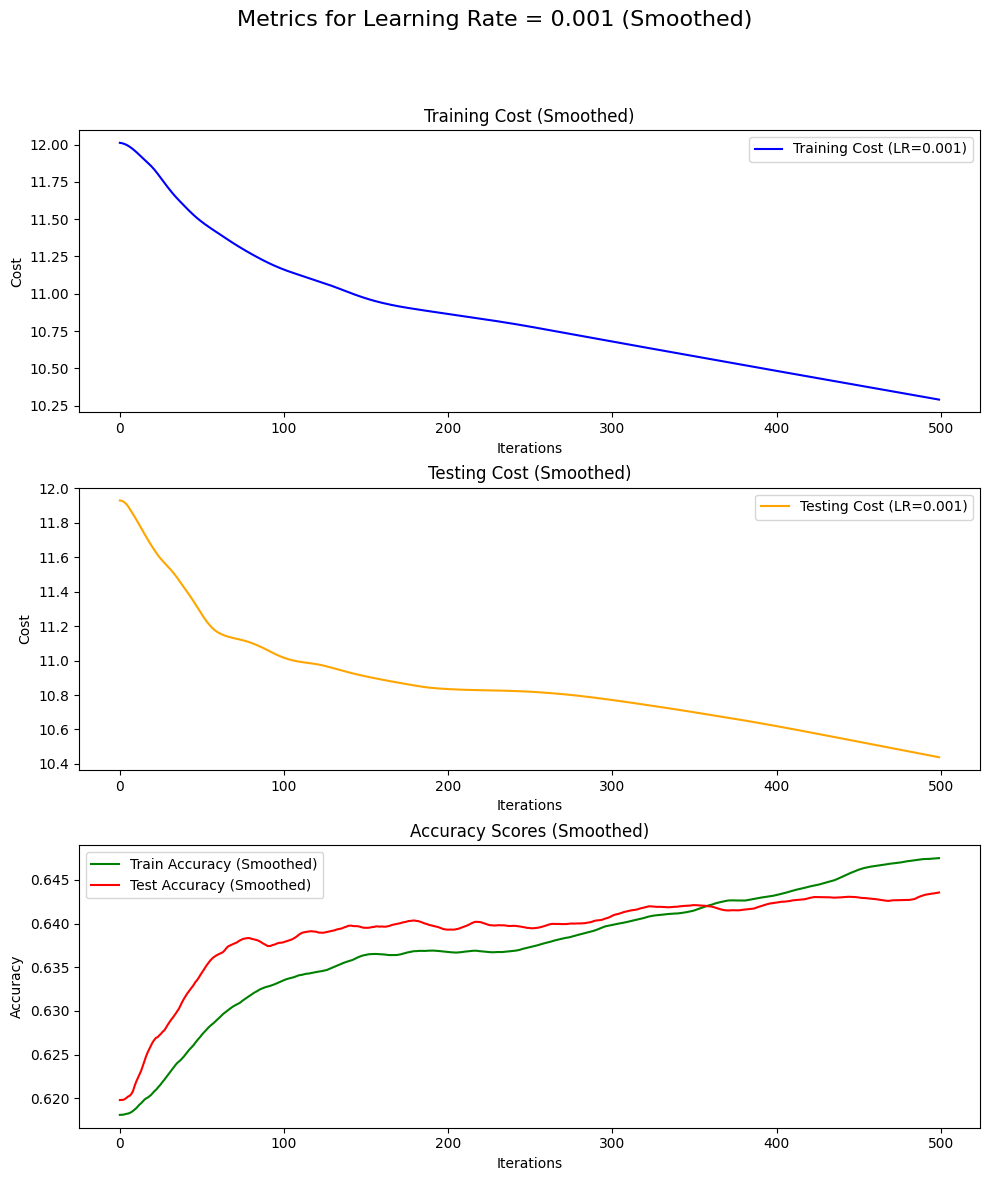

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Smoothing function using moving average
def smooth_curve(values, smoothing_factor=0.9):
    smoothed_values = []
    last = values[0]  # Initial point
    for point in values:
        smoothed_value = last * smoothing_factor + (1 - smoothing_factor) * point
        smoothed_values.append(smoothed_value)
        last = smoothed_value
    return smoothed_values

# Plotting results
def plot_results_separately_smoothed(results_per_lr, smoothing_factor=0.9):
    for lr in learning_rates:
        results = results_per_lr[lr]
        train_costs = smooth_curve(results['train_costs'], smoothing_factor)
        test_costs = smooth_curve(results['test_costs'], smoothing_factor)
        train_accuracies = smooth_curve(results['train_accuracies'], smoothing_factor)
        test_accuracies = smooth_curve(results['test_accuracies'], smoothing_factor)

        # Create a new figure for each learning rate
        fig, axs = plt.subplots(3, 1, figsize=(10, 12))
        fig.suptitle(f'Metrics for Learning Rate = {lr} (Smoothed)', fontsize=16)

        # Training cost plot
        axs[0].plot(train_costs, label=f'Training Cost (LR={lr})', color='blue')
        axs[0].set_title('Training Cost (Smoothed)')
        axs[0].set_xlabel('Iterations')
        axs[0].set_ylabel('Cost')
        axs[0].legend()

        # Testing cost plot
        axs[1].plot(test_costs, label=f'Testing Cost (LR={lr})', color='orange')
        axs[1].set_title('Testing Cost (Smoothed)')
        axs[1].set_xlabel('Iterations')
        axs[1].set_ylabel('Cost')
        axs[1].legend()

        # Accuracy scores plot
        axs[2].plot(train_accuracies, label='Train Accuracy (Smoothed)', color='green')
        axs[2].plot(test_accuracies, label='Test Accuracy (Smoothed)', color='red')
        axs[2].set_title('Accuracy Scores (Smoothed)')
        axs[2].set_xlabel('Iterations')
        axs[2].set_ylabel('Accuracy')
        axs[2].legend()

        # Adjust layout and show
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.show()

# Call the function to plot
plot_results_separately_smoothed(final_results)
